# Voorbeeld fragility curve piping

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from toolbox_continu_inzicht import Config, DataAdapter
from toolbox_continu_inzicht.fragility_curves import (
    FragilityCurvesPiping,
    CombineFragilityCurvesWeightedSum,
    CombineFragilityCurvesIndependent,
)

In [3]:
test_path = Path.cwd() / "../../../"
dataset_path = test_path / "src/fragility_curves/fragility_curves_piping/data_sets/"

# Lees originele config
config = Config(config_path=dataset_path / "test_fragility_multiple_curves_piping.yaml")
config.lees_config()

# Corrigeer rootdir
config.global_variables["rootdir"] = str(dataset_path)

# Pas output aan van csv naar dataframe
config.data_adapters["fragility_curves"]["type"] = "python"
del config.data_adapters["fragility_curves"]["file"]
del config.data_adapters["fragility_curves"]["sep"]

data_adapter = DataAdapter(config=config)

In [4]:
fragility_curve_piping = FragilityCurvesPiping(data_adapter=data_adapter)
fragility_curve_piping.run(
    input=["probabilistic_input", "waterlevels"], output="fragility_curves"
)
fragility_curve_piping.df_out

,waterlevels,failure_probability,section_id,scenario_id
0,0.0,1.955538e-32,1,1
1,0.1,1.020085e-31,1,1
2,0.2,5.351751e-31,1,1
3,0.3,2.820484e-30,1,1
4,0.4,1.491263e-29,1,1
...,...,...,...,...
598,19.6,1.000000e+00,2,2
599,19.7,1.000000e+00,2,2
600,19.8,1.000000e+00,2,2
601,19.9,1.000000e+00,2,2


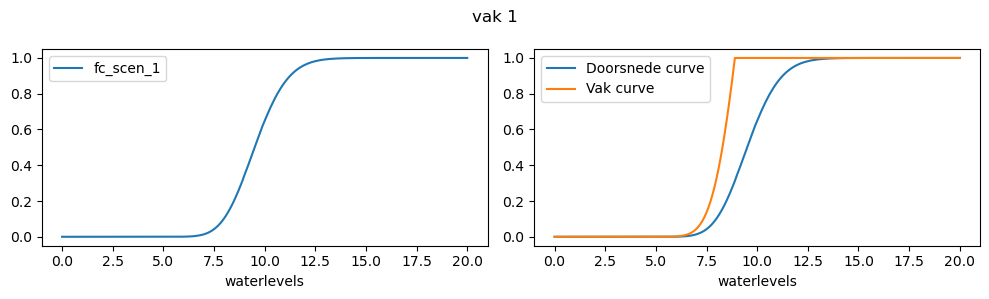

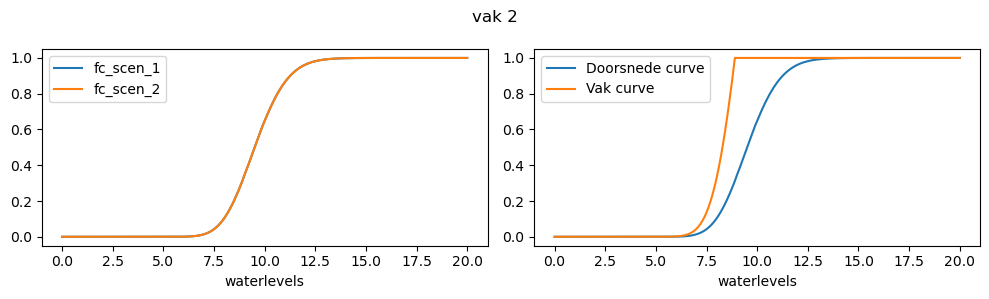

In [5]:
plt.close("all")

section_names = []
for sectionname, sectiongroup in fragility_curve_piping.df_out.groupby("section_id"):
    # Maak data adapters voor alle vakscenario's
    calc_names = []
    for scen_id, scen_fc in sectiongroup.groupby("scenario_id"):
        fc_name = f"fc_scen_{scen_id}"
        data_adapter.set_dataframe_adapter(fc_name, scen_fc, if_not_exist="create")
        calc_names.append(fc_name)

    # Maak gewichten voor de scenario's
    weights = np.ones(len(calc_names)) / len(calc_names)
    weights = pd.DataFrame({"weights": weights})
    data_adapter.set_dataframe_adapter("weights", weights, if_not_exist="create")
    calc_names.append("weights")

    # Combineer een of meerdere doorsnedescenario's tot 1 doorsnede curve
    comb_fc = CombineFragilityCurvesWeightedSum(data_adapter=data_adapter)
    comb_fc.run(input=calc_names, output="fragility_curves")
    calc_fc = comb_fc.df_out.copy()

    # Schaal doorsnedecurve naar vakcurve met lengte-effectfactor 3.2
    weights = pd.Series([3.2]).to_frame(name="weights")
    data_adapter.set_dataframe_adapter("weights", weights, if_not_exist="create")
    data_adapter.set_dataframe_adapter("calc_fc", calc_fc, if_not_exist="create")
    comb_fc = CombineFragilityCurvesWeightedSum(data_adapter=data_adapter)
    comb_fc.run(input=["calc_fc", "weights"], output="fragility_curves")
    section_fc = comb_fc.df_out.copy()

    # Sla vakcurve op
    fc_name = f"fc_section_{sectionname}"
    data_adapter.set_dataframe_adapter(fc_name, section_fc, if_not_exist="create")
    section_names.append(fc_name)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
    colx = "waterlevels"
    coly = "failure_probability"
    for calc_name in calc_names:
        if calc_name == "weights":
            continue
        data_adapter.input(calc_name).plot(colx, coly, ax=axs[0], label=calc_name)

    calc_fc.plot(colx, coly, ax=axs[1], label="Doorsnede curve")
    section_fc.plot(colx, coly, ax=axs[1], label="Vak curve")
    fig.suptitle(f"vak {sectionname}")
    fig.tight_layout()

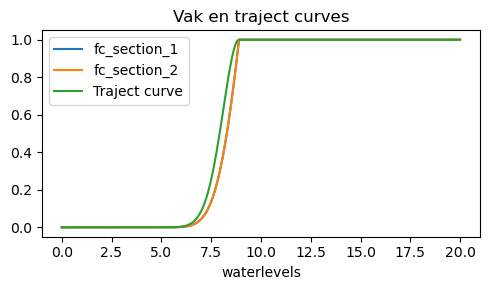

In [6]:
# Combineer meerdere vakken tot 1 curve
comb_fc = CombineFragilityCurvesIndependent(data_adapter=data_adapter)
comb_fc.run(input=section_names, output="fragility_curves")

plt.close("all")
colx = "waterlevels"
coly = "failure_probability"
fig, ax = plt.subplots(figsize=(5, 3))
for section_name in section_names:
    data_adapter.input(section_name).plot(colx, coly, ax=ax, label=section_name)
comb_fc.df_out.plot(colx, coly, ax=ax, label="Traject curve")
ax.set_title("Vak en traject curves")
fig.tight_layout()

In [7]:
comb_fc.df_out

,waterlevels,failure_probability,failuremechanismid
0,0.00,0.0,1
1,0.05,0.0,1
2,0.10,0.0,1
3,0.15,0.0,1
4,0.20,0.0,1
...,...,...,...
396,19.80,1.0,1
397,19.85,1.0,1
398,19.90,1.0,1
399,19.95,1.0,1
